# **Visualisation**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

**Data loading**

In [4]:
df = pd.read_csv('../data/final_data.zip')

# Data cleaning

In [5]:
df.head(25)

,ID_ANSSI,Titre,Type,Date,CVE,CVSS,Base Severity,CWE,EPSS,Lien,Description,Éditeur,Produit,Versions affectées,Remote exploitable,Longueur description
0,CERTFR-2023-AVI-0003,Multiples vulnérabilités dans les produits And...,Avis,2023-01-04T01:00:00.000000,CVE-2022-42720,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,Various refcounting bugs in the multi-BSS hand...,NaN,NaN,NaN,False,254
1,CERTFR-2023-AVI-0003,Multiples vulnérabilités dans les produits And...,Avis,2023-01-04T01:00:00.000000,CVE-2022-42721,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,A list management bug in BSS handling in the m...,NaN,NaN,NaN,False,240
2,CERTFR-2023-AVI-0003,Multiples vulnérabilités dans les produits And...,Avis,2023-01-04T01:00:00.000000,CVE-2022-23960,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,Certain Arm Cortex and Neoverse processors thr...,NaN,NaN,NaN,False,323
3,CERTFR-2023-AVI-0003,Multiples vulnérabilités dans les produits And...,Avis,2023-01-04T01:00:00.000000,CVE-2022-41674,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,An issue was discovered in the Linux kernel be...,NaN,NaN,NaN,False,192
4,CERTFR-2023-AVI-0008,Multiples vulnérabilités dans les produits IBM,Avis,2023-01-06T01:00:00.000000,CVE-2022-25647,7.7,Élevée,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,The package com.google.code.gson:gson before 2...,NaN,com.google.code.gson:gson,unspecified,False,184
5,CERTFR-2023-AVI-0008,Multiples vulnérabilités dans les produits IBM,Avis,2023-01-06T01:00:00.000000,CVE-2022-42004,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,"In FasterXML jackson-databind before 2.13.4, r...",NaN,NaN,NaN,False,272
6,CERTFR-2023-AVI-0008,Multiples vulnérabilités dans les produits IBM,Avis,2023-01-06T01:00:00.000000,CVE-2022-42003,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,In FasterXML jackson-databind before versions ...,NaN,NaN,NaN,False,254
7,CERTFR-2023-AVI-0010,Multiples vulnérabilités dans le noyau Linux d...,Avis,2023-01-06T01:00:00.000000,CVE-2022-42703,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,mm/rmap.c in the Linux kernel before 5.19.7 ha...,NaN,NaN,NaN,False,103
8,CERTFR-2023-AVI-0010,Multiples vulnérabilités dans le noyau Linux d...,Avis,2023-01-06T01:00:00.000000,CVE-2022-3567,4.6,Moyenne,CWE-362,NaN,https://www.cert.ssi.gouv.fr/openapi.json,A vulnerability has been found in Linux Kernel...,Linux,Kernel,NaN,False,338
9,CERTFR-2023-AVI-0010,Multiples vulnérabilités dans le noyau Linux d...,Avis,2023-01-06T01:00:00.000000,CVE-2022-3564,5.5,Moyenne,CWE-119,NaN,https://www.cert.ssi.gouv.fr/openapi.json,A vulnerability classified as critical was fou...,Linux,Kernel,NaN,False,359


In [343]:
df = pd.read_csv('../data_pour_TD_final/data.csv')

In [344]:
df.head(50)

,ID_ANSSI,Titre,Type,Date,CVE,CVSS,Base Severity,CWE,EPSS,Lien,Description,Éditeur,Produit,Versions affectées,Remote exploitable,Longueur description
0,CERTFR-2023-AVI-0003,Multiples vulnérabilités dans les produits And...,Avis,2023-01-04T01:00:00.000000,CVE-2022-42720,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,Various refcounting bugs in the multi-BSS hand...,NaN,NaN,NaN,False,254
1,CERTFR-2023-AVI-0003,Multiples vulnérabilités dans les produits And...,Avis,2023-01-04T01:00:00.000000,CVE-2022-42721,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,A list management bug in BSS handling in the m...,NaN,NaN,NaN,False,240
2,CERTFR-2023-AVI-0003,Multiples vulnérabilités dans les produits And...,Avis,2023-01-04T01:00:00.000000,CVE-2022-23960,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,Certain Arm Cortex and Neoverse processors thr...,NaN,NaN,NaN,False,323
3,CERTFR-2023-AVI-0003,Multiples vulnérabilités dans les produits And...,Avis,2023-01-04T01:00:00.000000,CVE-2022-41674,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,An issue was discovered in the Linux kernel be...,NaN,NaN,NaN,False,192
4,CERTFR-2023-AVI-0008,Multiples vulnérabilités dans les produits IBM,Avis,2023-01-06T01:00:00.000000,CVE-2022-25647,7.7,Élevée,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,The package com.google.code.gson:gson before 2...,NaN,com.google.code.gson:gson,unspecified,False,184
5,CERTFR-2023-AVI-0008,Multiples vulnérabilités dans les produits IBM,Avis,2023-01-06T01:00:00.000000,CVE-2022-42004,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,"In FasterXML jackson-databind before 2.13.4, r...",NaN,NaN,NaN,False,272
6,CERTFR-2023-AVI-0008,Multiples vulnérabilités dans les produits IBM,Avis,2023-01-06T01:00:00.000000,CVE-2022-42003,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,In FasterXML jackson-databind before versions ...,NaN,NaN,NaN,False,254
7,CERTFR-2023-AVI-0010,Multiples vulnérabilités dans le noyau Linux d...,Avis,2023-01-06T01:00:00.000000,CVE-2022-42703,NaN,NaN,Non disponible,NaN,https://www.cert.ssi.gouv.fr/openapi.json,mm/rmap.c in the Linux kernel before 5.19.7 ha...,NaN,NaN,NaN,False,103
8,CERTFR-2023-AVI-0010,Multiples vulnérabilités dans le noyau Linux d...,Avis,2023-01-06T01:00:00.000000,CVE-2022-3567,4.6,Moyenne,CWE-362,NaN,https://www.cert.ssi.gouv.fr/openapi.json,A vulnerability has been found in Linux Kernel...,Linux,Kernel,NaN,False,338
9,CERTFR-2023-AVI-0010,Multiples vulnérabilités dans le noyau Linux d...,Avis,2023-01-06T01:00:00.000000,CVE-2022-3564,5.5,Moyenne,CWE-119,NaN,https://www.cert.ssi.gouv.fr/openapi.json,A vulnerability classified as critical was fou...,Linux,Kernel,NaN,False,359


# **Visualisation**

**Severity level categorization function**

In [267]:
def cvss_to_severity(score):
    try:
        score = float(score)
        if score <= 3:
            return 'Faible'
        elif score <= 6:
            return 'Moyenne'
        elif score <= 8:
            return 'Élevée'
        else:
            return 'Critique'
    except:
        return 'Inconnu'

# 1. Histogram of severity levels (based on CVSS)

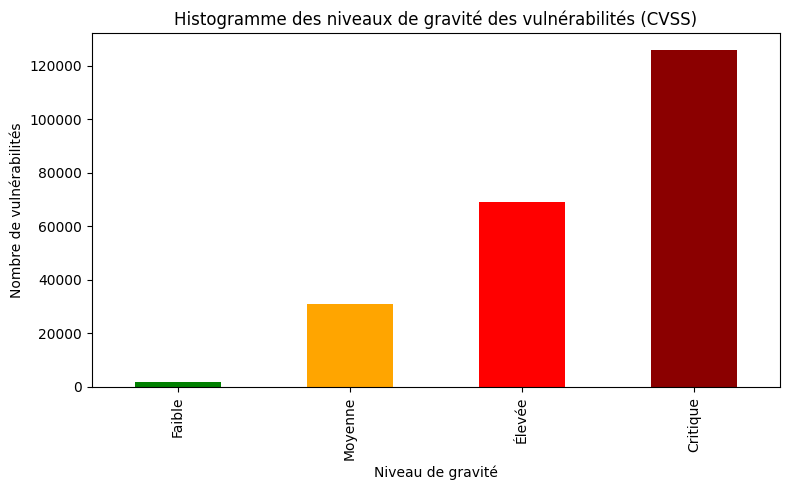

In [268]:
df['Gravité'] = df['CVSS'].apply(cvss_to_severity)
grav_counts = df['Gravité'].value_counts().reindex(['Faible', 'Moyenne', 'Élevée', 'Critique'], fill_value=0)

# Plot
plt.figure(figsize=(8,5))
grav_counts.plot(kind='bar', color=['green', 'orange', 'red', 'darkred', 'gray'])
plt.title('Histogramme des niveaux de gravité des vulnérabilités (CVSS)')
plt.xlabel('Niveau de gravité')
plt.ylabel('Nombre de vulnérabilités')
plt.tight_layout()
plt.show()

# 2. Circular vulnerability diagram (CWE)

Data cleaning

In [269]:
df['CWE'] = df['CWE'].fillna('Inconnu')

Top 10 most frequents, the other gouped by "Others"

In [270]:
top_cwe = df['CWE'].value_counts()
top_10 = top_cwe.head(10)
autres = top_cwe[12:].sum()
top_10['Autres'] = autres

Plot

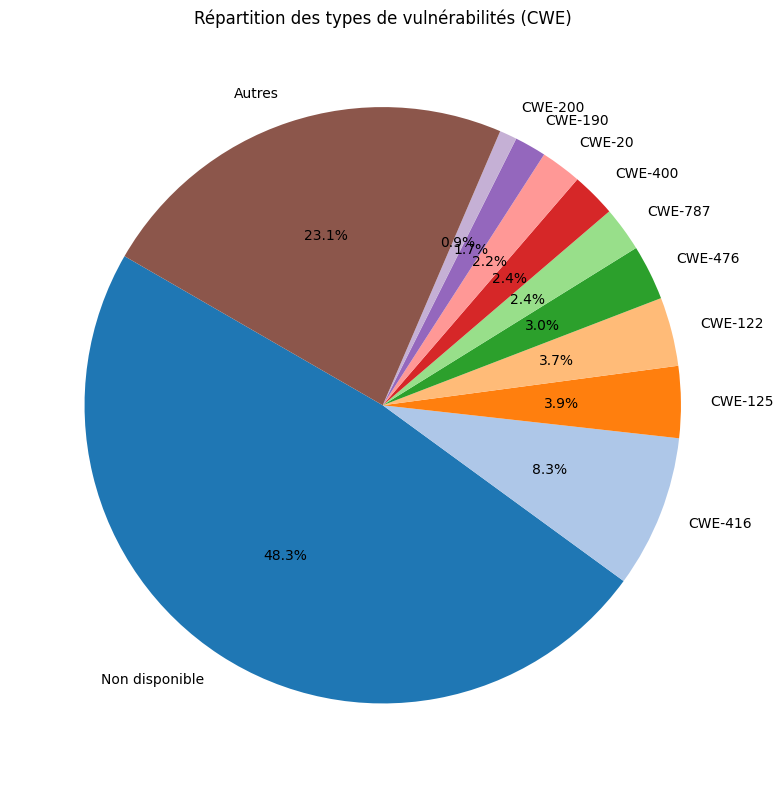

In [271]:
plt.figure(figsize=(8,8))
colors = plt.cm.tab20.colors[:len(top_10)]
top_10.plot(kind='pie', autopct='%1.1f%%', startangle=150, colors=colors)
plt.title('Répartition des types de vulnérabilités (CWE)')
plt.ylabel('')
plt.tight_layout()
plt.show()

# 3. EPSS Score Density Curve

Ensure EPSS scores are numeric

In [272]:
df['EPSS'] = pd.to_numeric(df['EPSS'], errors='coerce')
epss_valid = df['EPSS'].dropna()

Plot

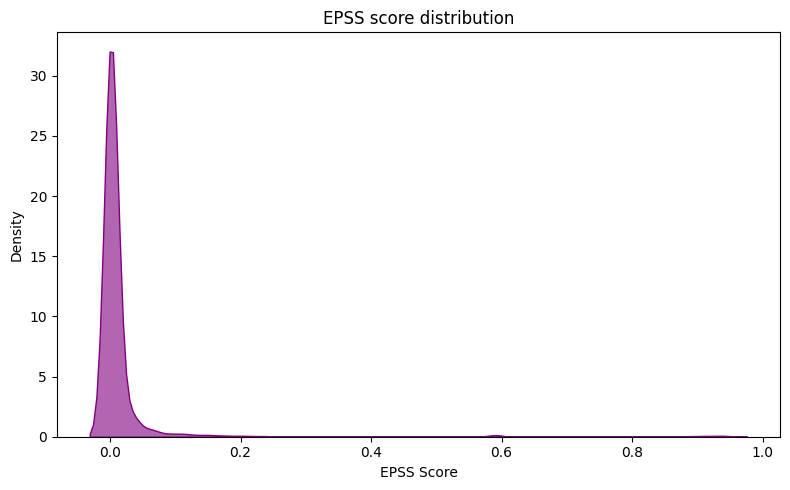

In [273]:
plt.figure(figsize=(8, 5))
sns.kdeplot(epss_valid, fill=True, color="purple", alpha=0.6)
plt.title('EPSS score distribution')
plt.xlabel('EPSS Score')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# 4. Top Affected editors

Count top 10 most frequently affected editors

In [274]:
top_editors = df['Éditeur'].value_counts().head(10)

Plot

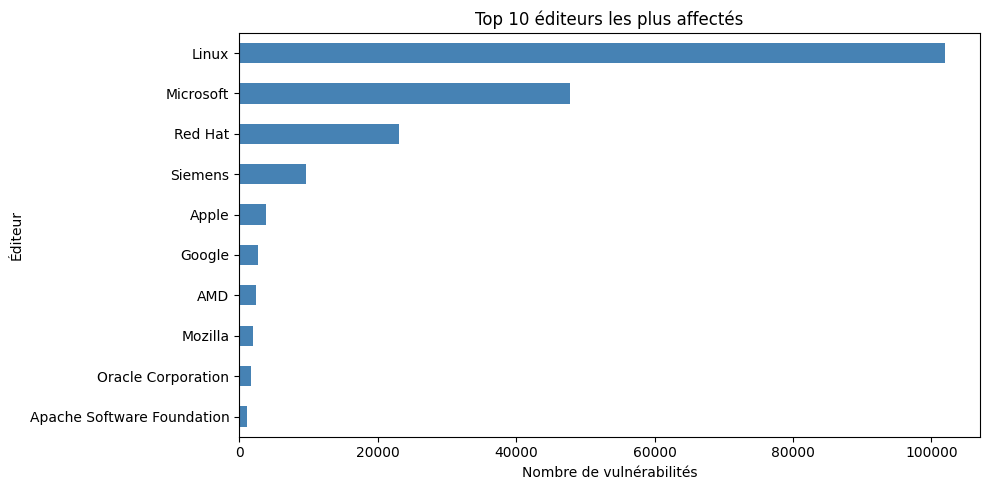

In [275]:
plt.figure(figsize=(10, 5))
top_editors.plot(kind='barh', color='steelblue')
plt.title('Top 10 éditeurs les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5. Top affected products

Count top 10 most frequently affected products

In [276]:
top_products = df['Produit'].value_counts().head(10)

Plot

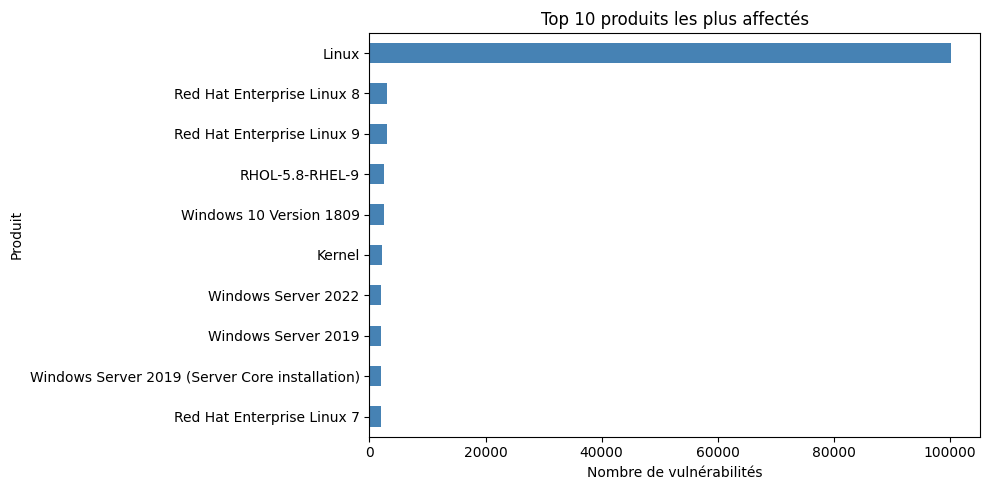

In [277]:
plt.figure(figsize=(10, 5))
top_products.plot(kind='barh', color='steelblue')
plt.title('Top 10 produits les plus affectés')
plt.xlabel('Nombre de vulnérabilités')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 6. Heatmap : Correlation between CVSS and EPSS

In [278]:
df["CVSS"] = pd.to_numeric(df["CVSS"], errors="coerce")

Create a correlation dataframe

In [279]:
correlation_df = df[["CVSS", "EPSS"]].dropna()

In [280]:
df["Gravité_CVSS"] = df["CVSS"].apply(cvss_to_severity)

Categorize EPSS into 4 probability bins

In [281]:
def epss_to_level(epss):
    if epss <= 0.25:
        return "Faible"
    elif epss <= 0.5:
        return "Moyenne"
    elif epss <= 0.75:
        return "Élevée"
    else:
        return "Critique"

In [282]:
df["Probabilité_EPSS"] = df["EPSS"].apply(epss_to_level)

Create heatmap

In [283]:
heatmap_data = pd.crosstab(df["Gravité_CVSS"], df["Probabilité_EPSS"])
heatmap_data = heatmap_data.reindex(index=["Critique", "Élevée", "Moyenne", "Faible"],
                                     columns=["Faible", "Moyenne", "Élevée", "Critique"])

Plot

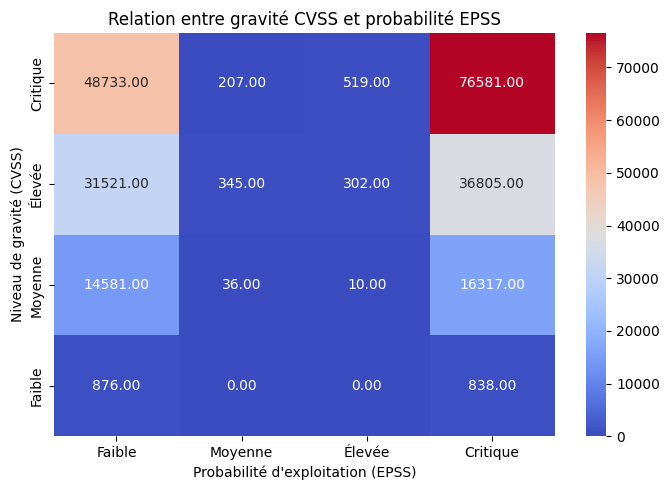

In [284]:
plt.figure(figsize=(7, 5))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Relation entre gravité CVSS et probabilité EPSS")
plt.xlabel("Probabilité d'exploitation (EPSS)")
plt.ylabel("Niveau de gravité (CVSS)")
plt.tight_layout()
plt.show()

# 7. Scatter plot : CVSS vs EPSS

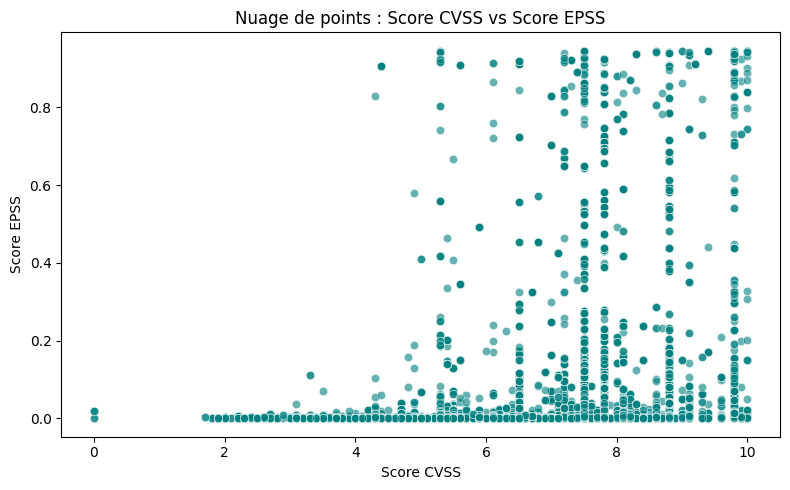

In [285]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="CVSS", y="EPSS", alpha=0.6, color="teal")
plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.tight_layout()
plt.show()

# 8. Cumulative curve: Vulnerabilities over time

In [286]:
df_sorted = df.sort_values("Date").dropna(subset=["Date"])

In [291]:
df_sorted['Date'] = pd.to_datetime(df_sorted['Date'], format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')

Group by date and calculate cumulative sum

In [292]:
cumulative_df = df_sorted.groupby("Date").size().cumsum()

Plot

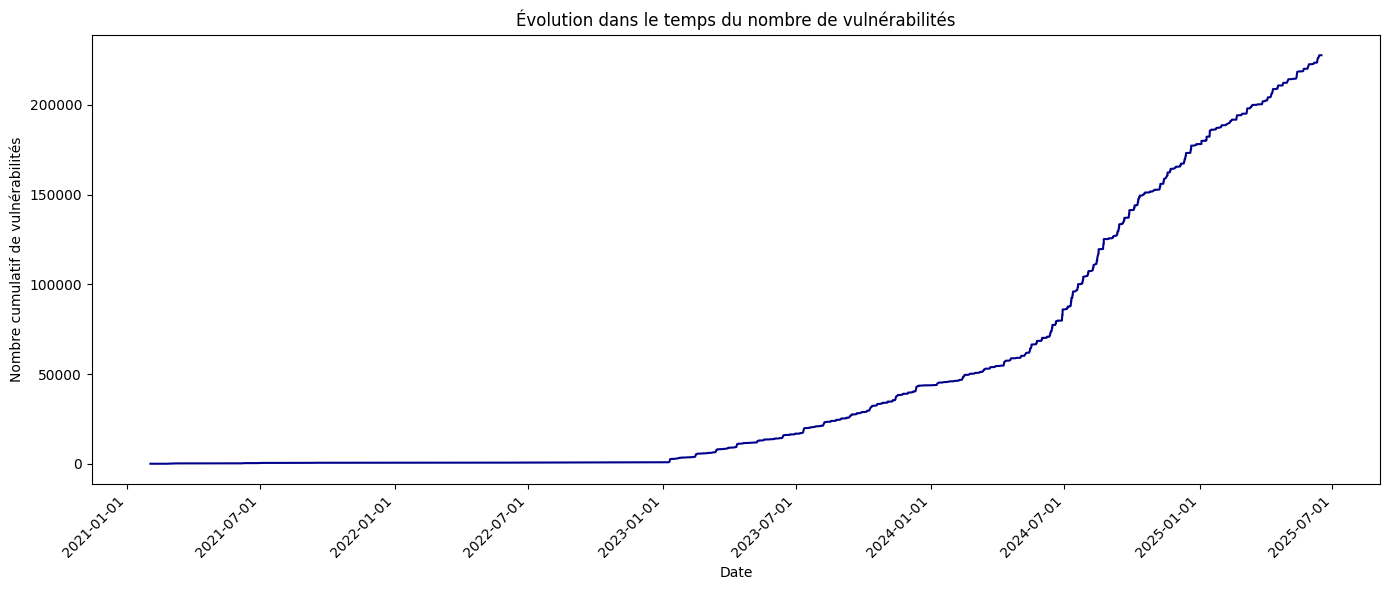

In [293]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(cumulative_df.index, cumulative_df.values, color="darkblue")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45, ha='right')

plt.title("Évolution dans le temps du nombre de vulnérabilités")
plt.xlabel("Date")
plt.ylabel("Nombre cumulatif de vulnérabilités")
plt.tight_layout()
plt.show()

# 9. Boxplot : CVSS scores by top editors

Filter

In [294]:
top_editors = df['Éditeur'].value_counts().head(10).index
boxplot_df = df[df['Éditeur'].isin(top_editors)]

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_28712\3526360994.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')


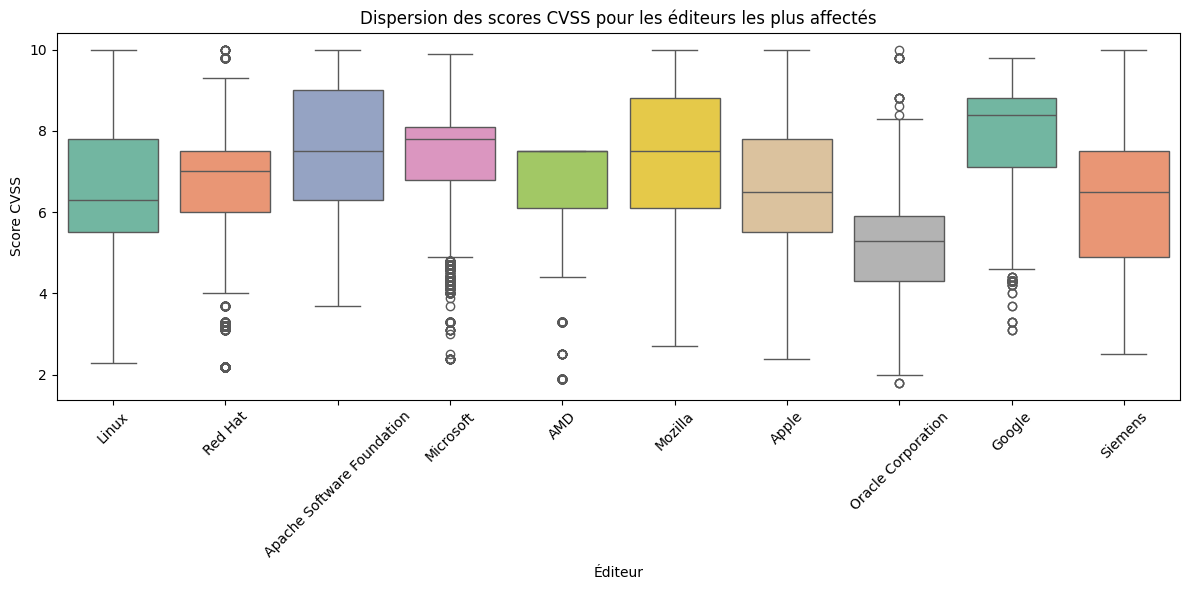

In [295]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=boxplot_df, x='Éditeur', y='CVSS', palette='Set2')
plt.title('Dispersion des scores CVSS pour les éditeurs les plus affectés')
plt.xlabel('Éditeur')
plt.ylabel('Score CVSS')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10. Time evolution of CWE-79 vulnerabilities (Cross-Site Scripting)

In [296]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
cwe_79_df = df[df["CWE"] == "CWE-79"]

Group by month

In [297]:
cwe_79_monthly = cwe_79_df.groupby(df["Date"].dt.to_period("M")).size()
cwe_79_monthly.index = cwe_79_monthly.index.to_timestamp()

Plot

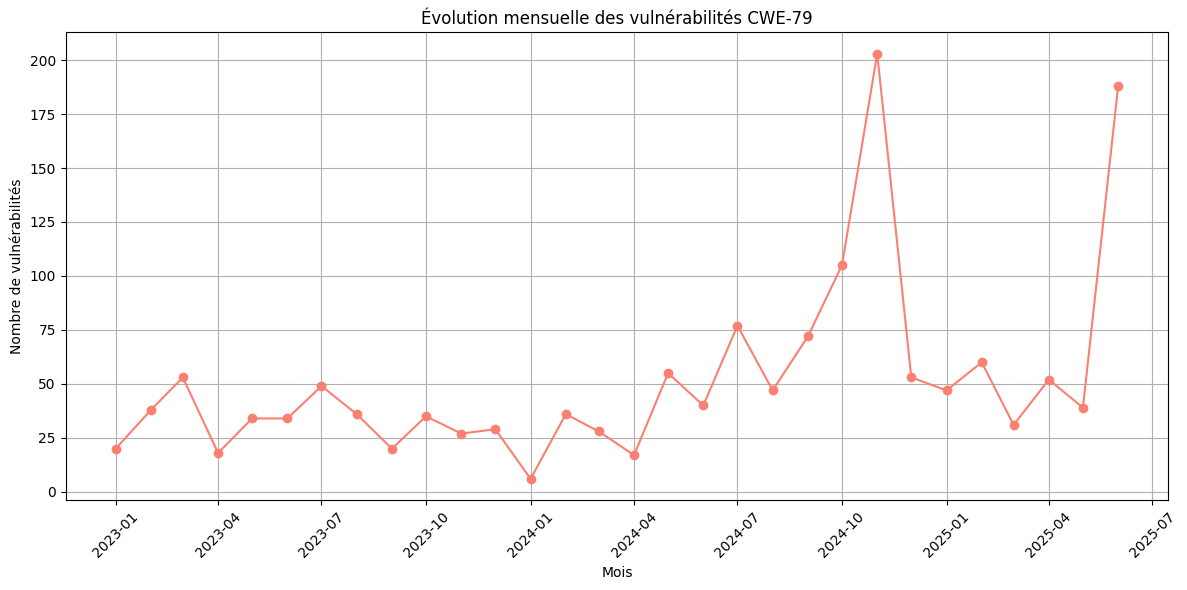

In [298]:

plt.figure(figsize=(12, 6))
plt.plot(cwe_79_monthly.index, cwe_79_monthly.values, marker="o", linestyle="-", color="salmon")
plt.title("Évolution mensuelle des vulnérabilités CWE-79")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 11. Histogram of vulnerabilities by product for a given CWE

Selection of CWE-125

In [299]:
cwe_cible = "CWE-125"
df_cwe = df[df["CWE"] == cwe_cible]

Count vulnerabilities by product

In [300]:
produit_counts = df_cwe["Produit"].value_counts().sort_values(ascending=False).head(15)

Plot

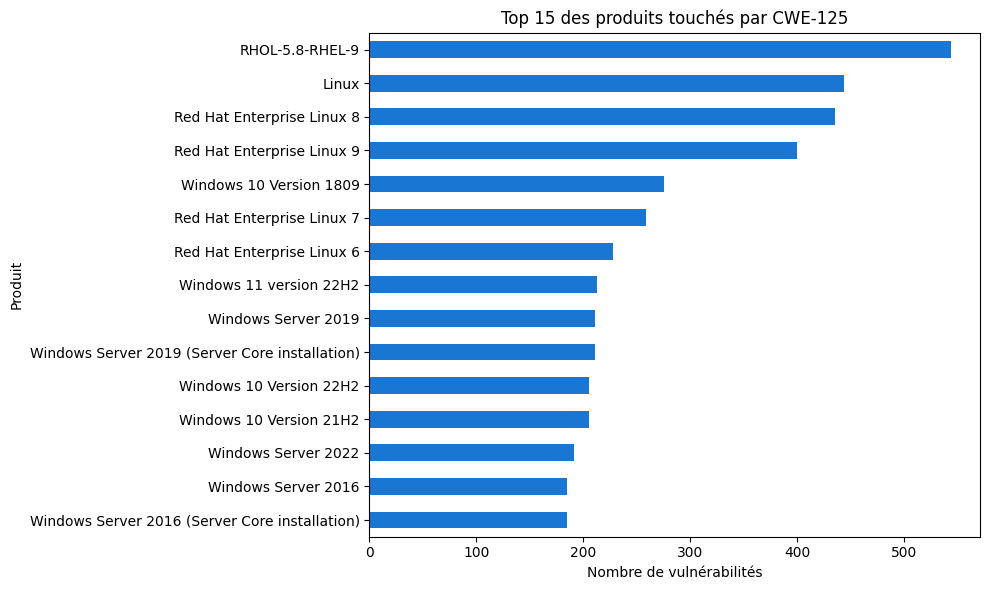

In [301]:
plt.figure(figsize=(10,6))
produit_counts.plot(kind="barh", color="#1976D2")
plt.gca().invert_yaxis()
plt.title(f"Top 15 des produits touchés par {cwe_cible}")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Produit")
plt.tight_layout()
plt.show()

# 12. Heatmap CWE x editor

Cleaning

In [302]:
df["Éditeur"] = df["Éditeur"].fillna("Non précisé")

Heatmap

In [303]:
heatmap_data = pd.crosstab(df["CWE"], df["Éditeur"])

Selection (if not too many values)

In [304]:
top_cwe = heatmap_data.sum(axis=1).sort_values(ascending=False).head(15).index
top_editeurs = heatmap_data.sum(axis=0).sort_values(ascending=False).head(14).index
filtered_data = heatmap_data.loc[top_cwe, top_editeurs]

Plot

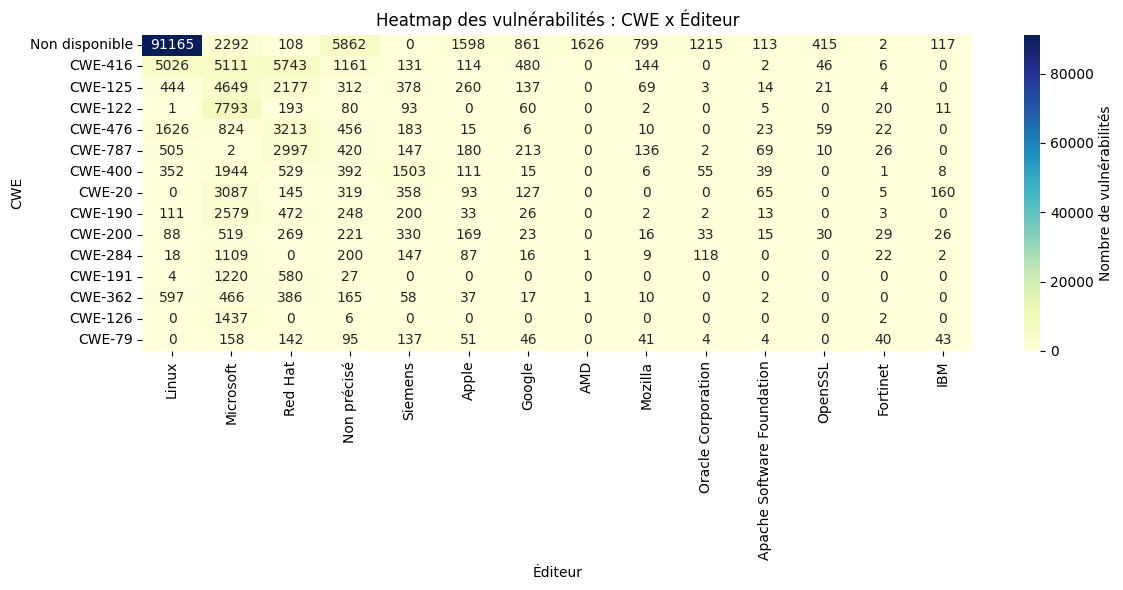

In [305]:
plt.figure(figsize=(12, 6))
sns.heatmap(filtered_data, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Nombre de vulnérabilités'})
plt.title("Heatmap des vulnérabilités : CWE x Éditeur")
plt.xlabel("Éditeur")
plt.ylabel("CWE")
plt.tight_layout()
plt.show()

# 13. Monthly vulnerability trends by CWE (superimposed curves)

Extraction of the month and the year

In [306]:
df["Mois"] = df["Date"].dt.to_period("M")  # Format AAAA-MM

Keep only the 8 most frequent CWE

In [307]:
top_cwes = df[df["CWE"] != "Non disponible"]["CWE"].value_counts().head(5).index
df_top = df[df["CWE"].isin(top_cwes)]

Grouping: number of vulnerabilities per month and per CWE

In [308]:
df_grouped = df_top.groupby(["Mois", "CWE"]).size().unstack(fill_value=0)

Plot

<Figure size 1200x600 with 0 Axes>

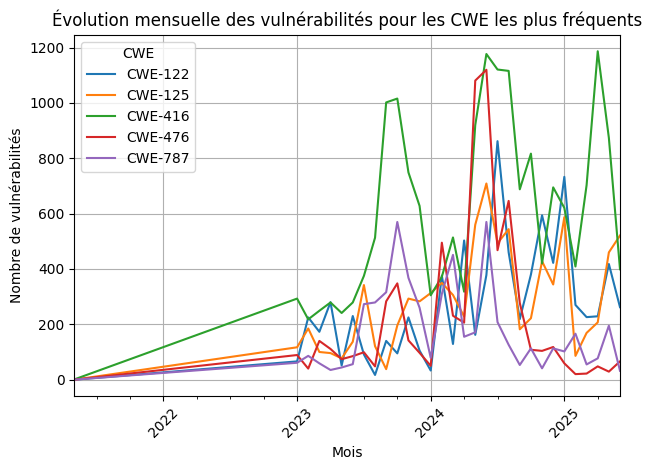

In [309]:
plt.figure(figsize=(12, 6))
df_grouped.plot()
plt.title("Évolution mensuelle des vulnérabilités pour les CWE les plus fréquents")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.legend(title="CWE")
plt.tight_layout()
plt.grid(True)
plt.show()

# 14. Heatmap : temporal vunerabilities

In [310]:
df["Année"] = df["Date"].dt.year
df["Mois"] = df["Date"].dt.month

In [311]:
pivot = pd.crosstab(df["Année"], df["Mois"]).fillna(0)

Plot

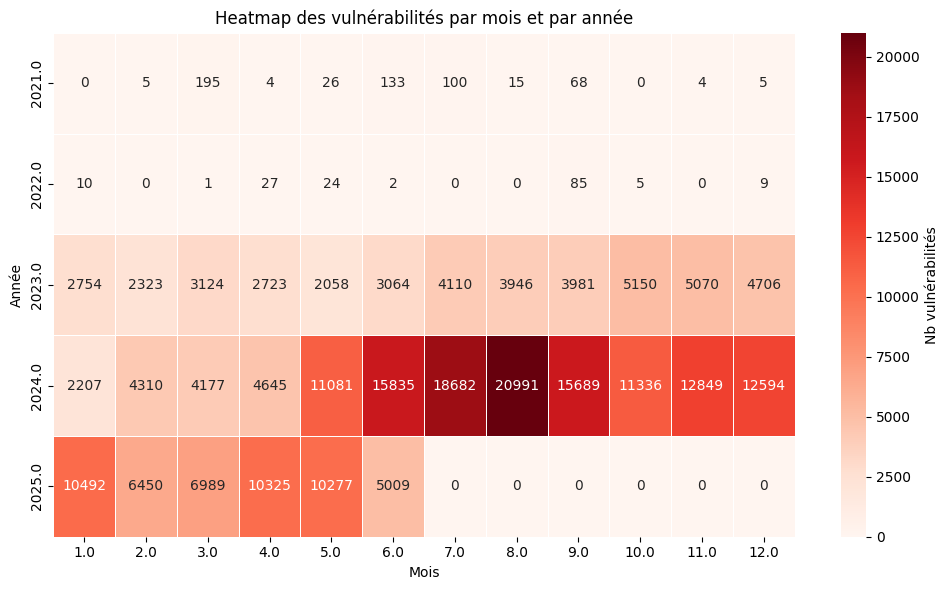

In [312]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".0f", linewidths=.5, cbar_kws={'label': 'Nb vulnérabilités'})
plt.title("Heatmap des vulnérabilités par mois et par année")
plt.xlabel("Mois")
plt.ylabel("Année")
plt.tight_layout()
plt.show()

# 15. Scatter : product & version

Clean and filter

In [313]:
df_filtered = df.dropna(subset=["Produit", "Versions affectées"])
df_filtered = df_filtered[df_filtered["Produit"] != "n/a"]
top_produits = df_filtered["Produit"].value_counts().head(25).index
top_versions = df_filtered["Versions affectées"].value_counts().head(15).index
df_top_both = df_filtered[
    (df_filtered["Produit"].isin(top_produits)) &
    (df_filtered["Versions affectées"].isin(top_versions))
]


In [314]:
df_top_both.loc[:, "Versions affectées"] = df_top_both["Versions affectées"].apply(
    lambda v: v if len(v) <= 20 else v[:17] + "..."
)

Plot

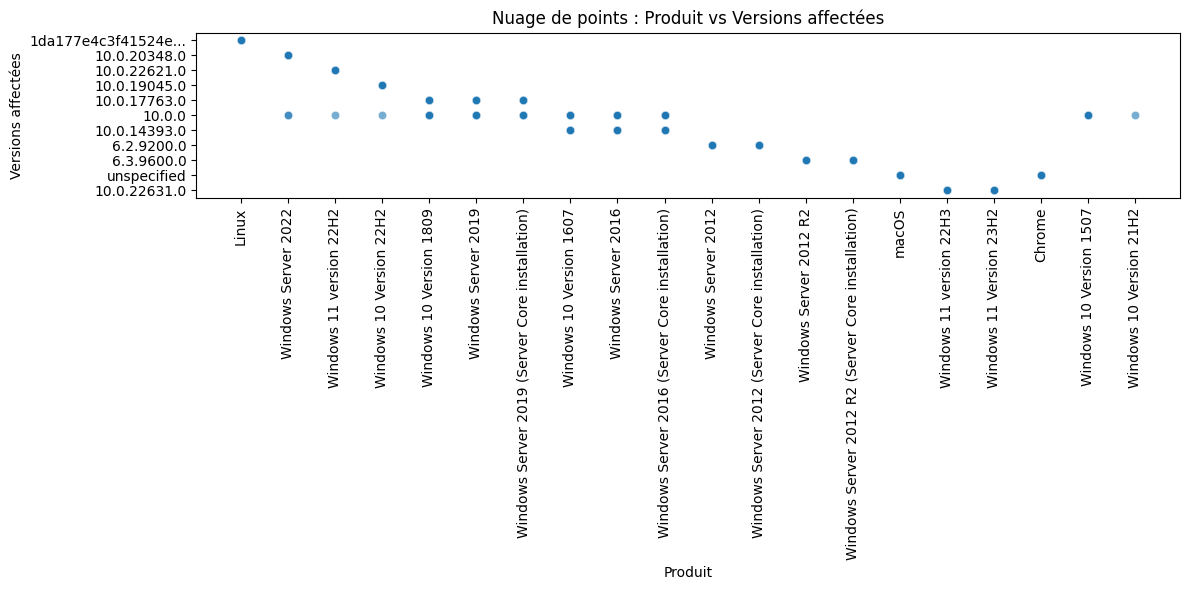

In [315]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_top_both, x="Produit", y="Versions affectées", alpha=0.6)

plt.xticks(rotation=90)
plt.title("Nuage de points : Produit vs Versions affectées")
plt.xlabel("Produit")
plt.ylabel("Versions affectées")
plt.tight_layout()
plt.show()

# 16. Bar chart : top 10 versions most impacted by vulnerabilities

Filter

In [316]:
versions = df["Versions affectées"].dropna()
versions = versions[versions != "n/a"]

Shorten the name if too long

In [317]:
versions_short = versions.apply(lambda v: v if len(v) <= 20 else v[:17] + "...")


In [318]:
version_counts = versions_short.value_counts().head(10)

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_28712\2037418214.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")


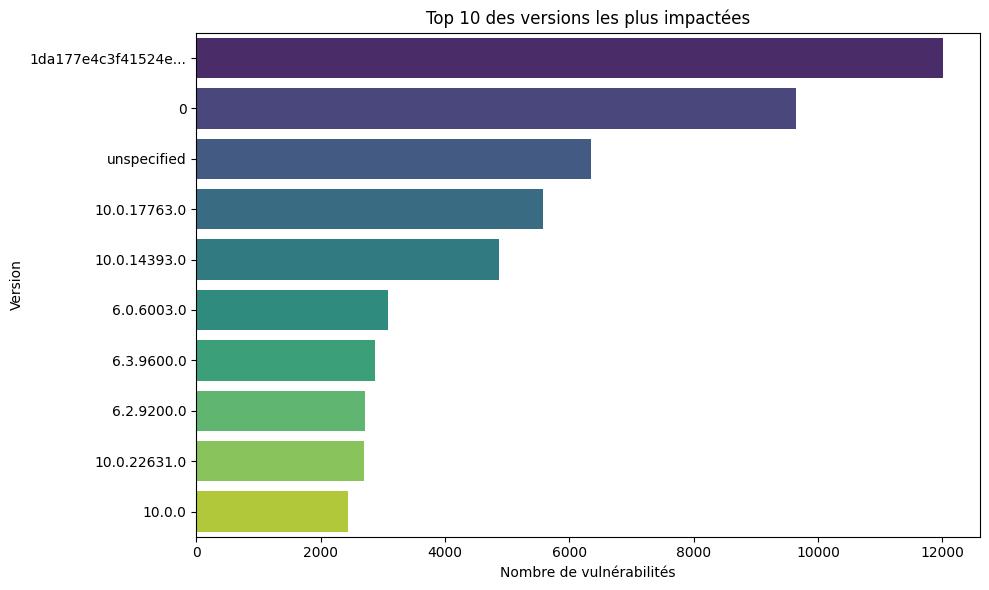

In [319]:
plt.figure(figsize=(10, 6))
sns.barplot(y=version_counts.index, x=version_counts.values, palette="viridis")

plt.title("Top 10 des versions les plus impactées")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Version")
plt.tight_layout()
plt.show()

# 17. Temporal evolution of vulnerabilities by bulletin type (Avis/Alertes)

In [320]:
df['Type'] = df['Type'].str.strip() 
df = df[df['Type'].isin(['Avis', 'Alerte'])]

In [321]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Mois'] = df['Date'].dt.to_period('M').astype(str)

Group by month and type (avis/alerte)

In [322]:
df_evol = df.groupby(['Mois', 'Type']).size().reset_index(name='Nombre')

Sort by chronological month

In [323]:
df_evol['Mois'] = pd.to_datetime(df_evol['Mois'])
df_evol = df_evol.sort_values('Mois')

Plot

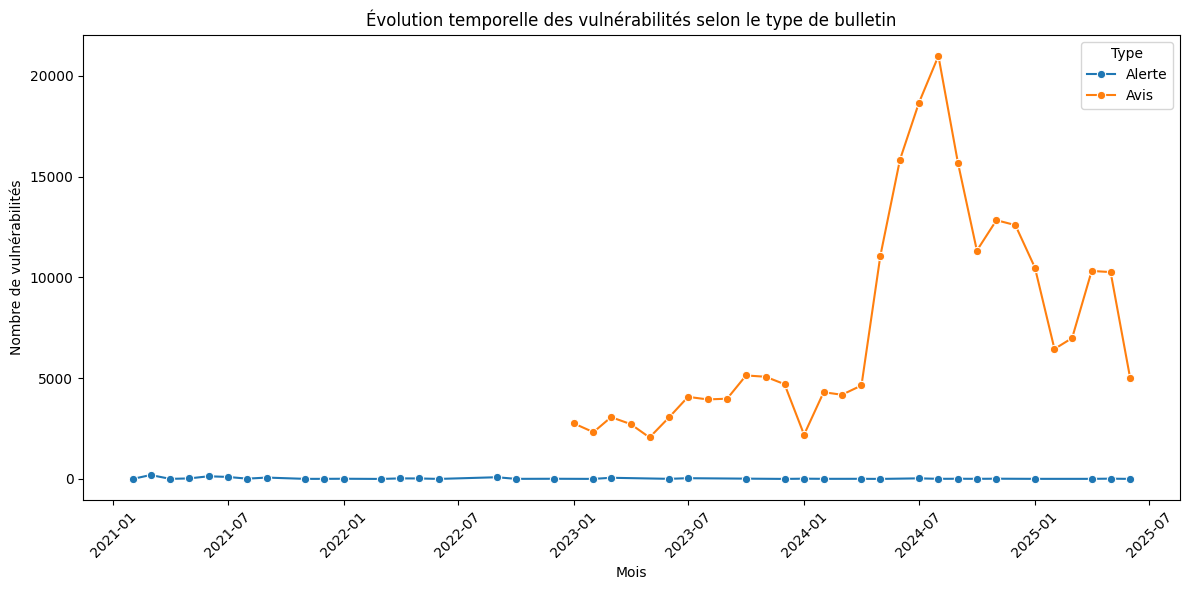

In [324]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_evol, x='Mois', y='Nombre', hue='Type', marker='o')
plt.title("Évolution temporelle des vulnérabilités selon le type de bulletin")
plt.xlabel("Mois")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 18. Vulnerability by editor and type (alerte/avis)

Group by editor and type

In [325]:
df_bar = df.groupby(['Éditeur', 'Type']).size().unstack(fill_value=0)

Keep 15 most frequents editors

In [326]:
df_bar = df_bar.sort_values(df_bar.columns.tolist(), ascending=False).head(15)

Plot

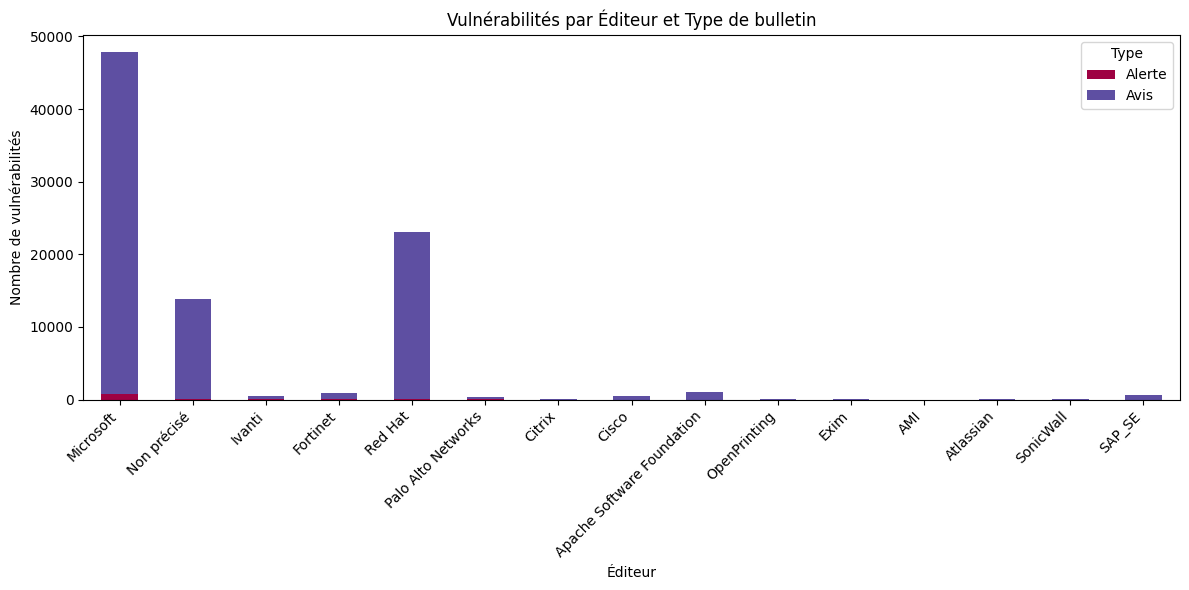

In [327]:

df_bar.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Spectral')
plt.title("Vulnérabilités par Éditeur et Type de bulletin")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# 19. Boxplot - Gravity (CVSS) by bulletin type

Plot

C:\Users\eva2p\AppData\Local\Temp\ipykernel_28712\3635914293.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Type", y="CVSS", palette="Set1")


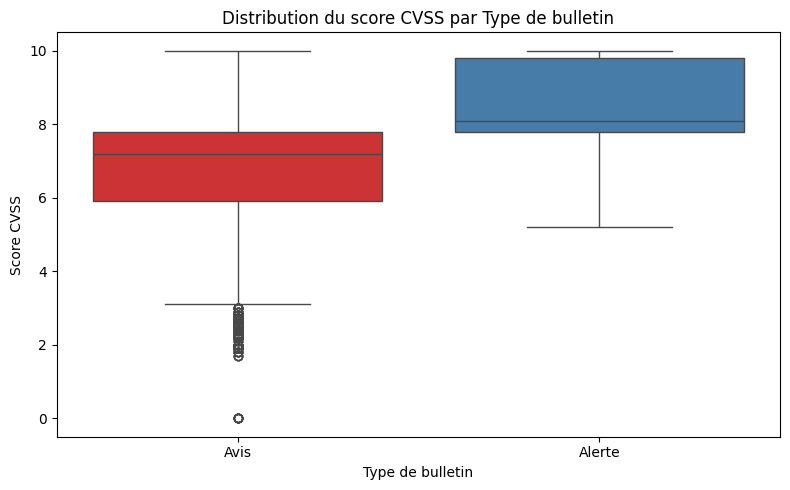

In [328]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Type", y="CVSS", palette="Set1")
plt.title("Distribution du score CVSS par Type de bulletin")
plt.xlabel("Type de bulletin")
plt.ylabel("Score CVSS")
plt.tight_layout()
plt.show()

# 20. Heatmap : number of vulnerabilities

Cleaning data

In [329]:
df['Base Severity'] = df['Base Severity'].fillna('Non spécifié')
df['Éditeur'] = df['Éditeur'].fillna('Non spécifié')

Keeping 15 most frequents editors

In [330]:
top_editeurs = df['Éditeur'].value_counts().head(15).index
df_top = df[df['Éditeur'].isin(top_editeurs)]

Heatmap

In [331]:
heat_data = df_top.groupby(['Éditeur', 'Base Severity']).size().unstack(fill_value=0)
severity_order = ['Critique', 'Élevée', 'Moyenne', 'Faible', 'Non spécifié']
heat_data = heat_data[[s for s in severity_order if s in heat_data.columns]]

Plot

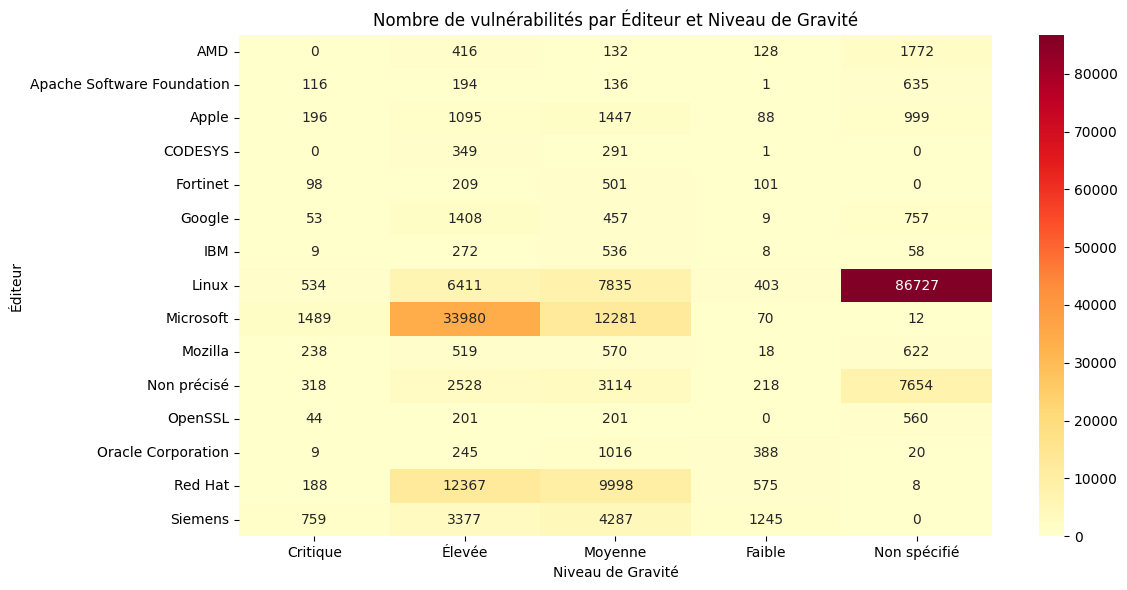

In [332]:
plt.figure(figsize=(12, 6))
sns.heatmap(heat_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Nombre de vulnérabilités par Éditeur et Niveau de Gravité")
plt.xlabel("Niveau de Gravité")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()